# 3 Ex3. Seasonality

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [5]:
holidays_path="../data/holidays_events.csv"
holidays_events = pd.read_csv( holidays_path,
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [6]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
store_path="../data/store_sales/train.csv.zip"
store_sales = pd.read_csv(
    store_path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [8]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

## 3.1 Analyze the seasonality of store sales data

Below code shows the seasonal plot of store sales

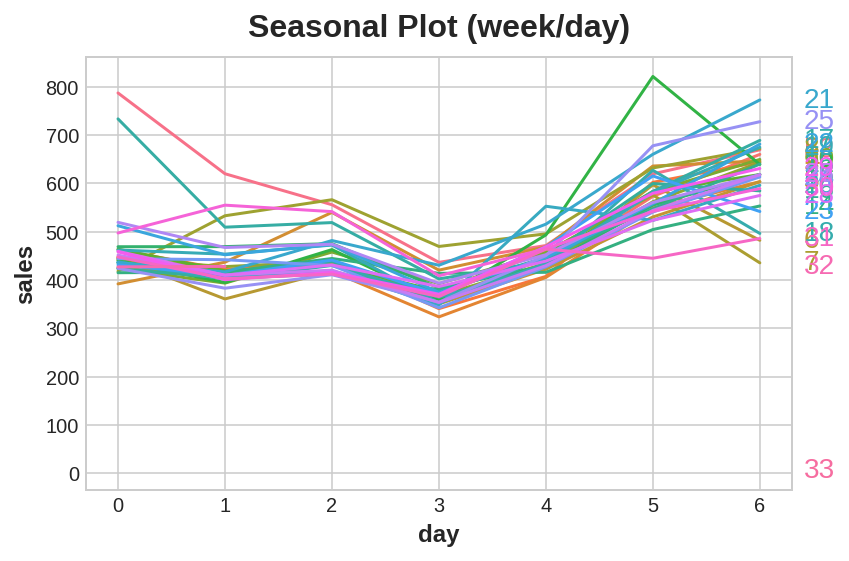

In [9]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

Below code shows the periodogram of store sales

/tmp/ipykernel_3630/1310754901.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales);


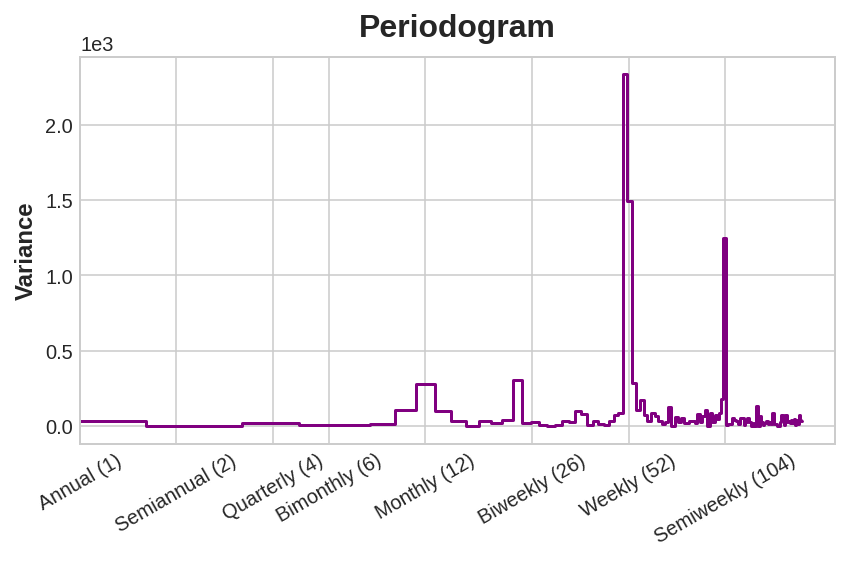

In [10]:
plot_periodogram(average_sales);

## 3.1.1 Question What kind of seasonality do you see?

What kind of seasonality do you see of the store sales data based on the above `seasonal plot` and `periodogram` ?

``` text
Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram,
it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales
dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.
```

## 3.2 Create seasonal features

Use `DeterministicProcess` and `CalendarFourier` to create:

- indicators for weekly seasons and
- Fourier features of order 4 for monthly seasons.

In [12]:
y = average_sales.copy()

# need to understand the parameter of CalendarFourier function
fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

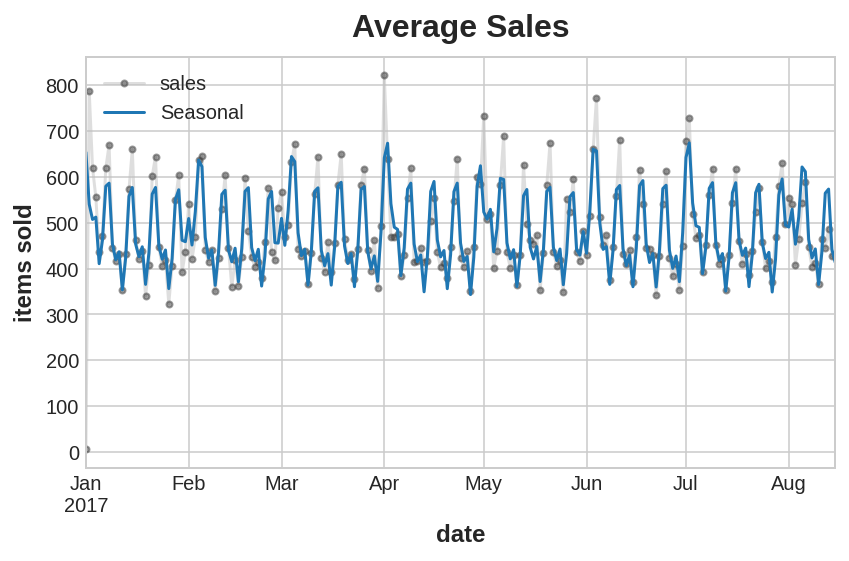

In [13]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.
​
Look at the periodogram of the deseasonalized series.

/tmp/ipykernel_3630/77330024.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax1 = plot_periodogram(y, ax=ax1)
/tmp/ipykernel_3630/77330024.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax2 = plot_periodogram(y_deseason, ax=ax2);


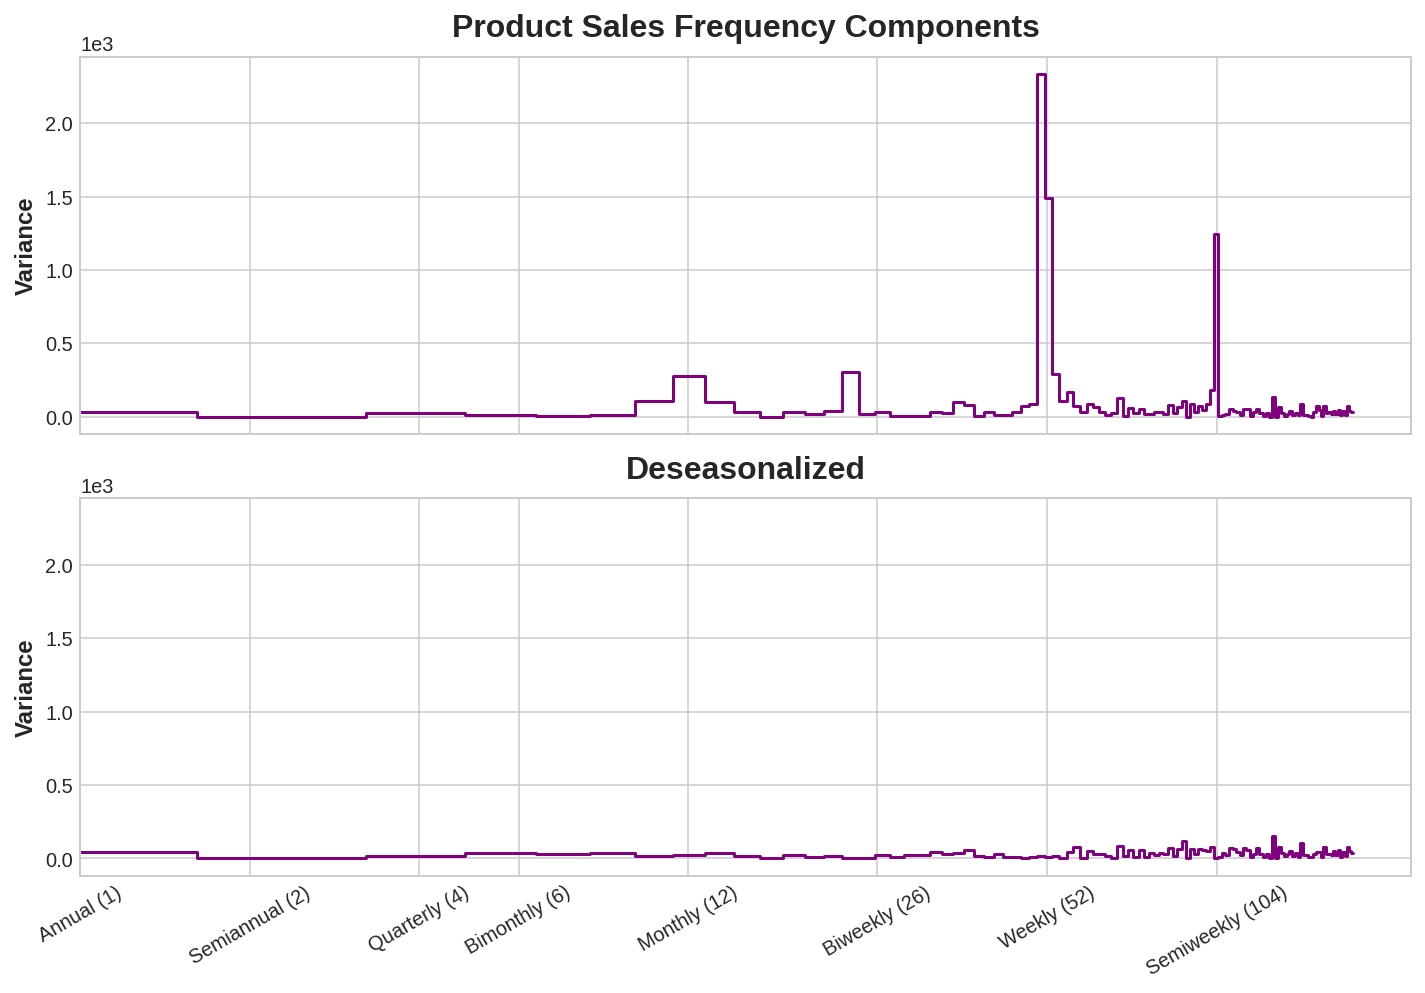

In [14]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

# 3.3 Check for remaining seasonality

Based on these periodograms, how effectively does it appear your model captured the seasonality in *Average Sales*? Does the periodogram agree with the time plot of the deseasonalized series?

```text
The periodogram for the deseasonalized series lacks any large values. By comparing it to the
periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.


```

## 3.3.1

The Store Sales dataset includes a table of Ecuadorian holidays.

In [15]:
from IPython.core.display_functions import display

# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized *Average Sales*, it appears these holidays could have some predictive power.

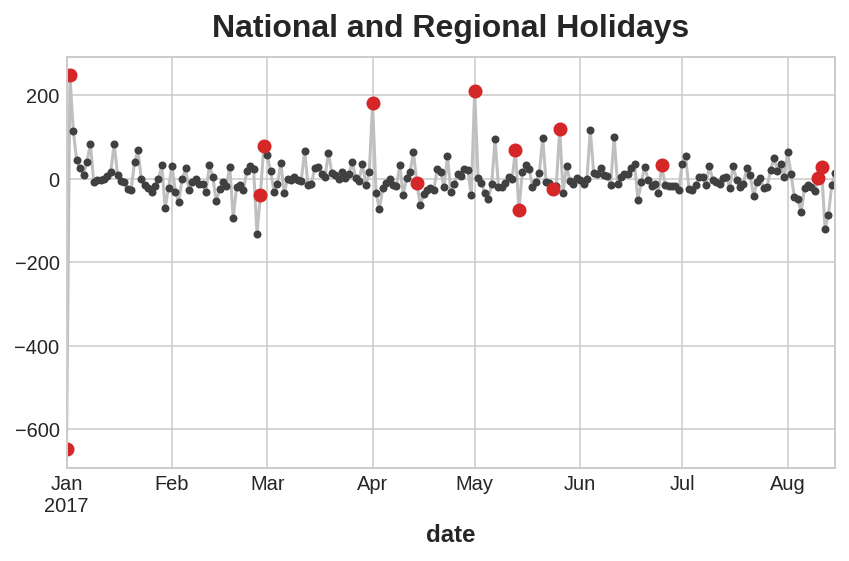

In [16]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

## 3.4 Create holiday features

What kind of features could you create to help your model make use of this information? Code your answer in the next cell. (Scikit-learn and Pandas both have utilities that should make this easy. See the `hint` if you'd like more details.)

Hint 1: With Pandas, you could use pd.get_dummies. With scikit-learn, you could use sklearn.preprocessing.OneHotEncoder. Using Pandas makes it easier to join X_holidays to X2 since it returns a DataFrame retaining the date of each holiday. (For another hint, call .hint(2))

Hint 2: In Pandas, your solution would look like:

X_holidays = pd.get_dummies(____)

X2 = X.join(X_holidays, on='date').fillna(0.0)
In scikit-learn, your solution would look like:

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ____,
    index=____,
    columns=holidays.description.unique(),  # optional,  but nice to have
)

X2 = X.join(X_holidays, on='date').fillna(0.0)


In [17]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)


In [ ]:
# Pandas solution
X_holidays = pd.get_dummies(holidays)


In [18]:
# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

Use this cell to fit the seasonal model with holiday features added. Do the fitted values seem to have improved?

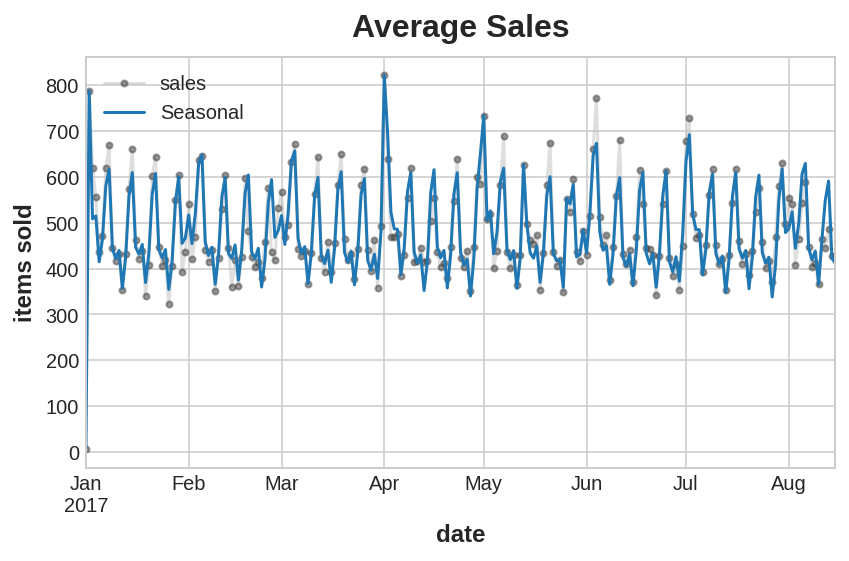

In [19]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();